In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [3]:
#set default styling for plots
sns.set(style='ticks', context='talk')
sns.set_style("dark")

In [4]:
#load the train and test sets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Inspect Train + Test Sets
Summary: From this inspection, we see that there are five columns that contain nulls, with the monthly rent payment column ('v2a1') having the higheset null count. We also see that the test data set is 2.5 times the size of the training data set. There are 142 features in the training data set.

In [5]:
len(train)

9557

In [6]:
len(test)

23856

In [7]:
train.shape

(9557, 143)

In [8]:
test.shape

(23856, 142)

In [9]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [10]:
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [11]:
null_columns_train = train.columns[train.isnull().any()]
print(train[null_columns_train].isnull().sum())

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64


In [12]:
null_columns_test = test.columns[test.isnull().any()]
print(test[null_columns_test].isnull().sum())

v2a1         17403
v18q1        18126
rez_esc      19653
meaneduc        31
SQBmeaned       31
dtype: int64


## Exploratory Data Analysis
### Household Size
The household feature ('tamhog') skews right and the median household size is 4 people. The non-vulnerable households tend to have 2-4 people, whereas the extreme poverty households tend to have more than 6 people living in the house. This shows that household size could be a strong feature for helping predict poverty level. Extreme poverty peaks at 10-14 people in the household, whereas moderate poverty peaks at 5-6 people. Vulnerable poverty decreases as the household size grows, giving way to a rise in moderate and extreme poverty.

Text(0.5,0,'Size of Household')

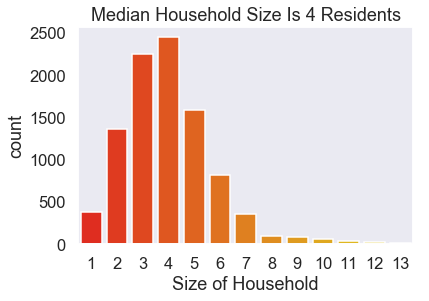

In [13]:
sns.countplot(train['tamhog'][train['tamhog'].notnull()], palette=("autumn"))
plt.title('Median Household Size Is 4 Residents')
plt.xlabel('Size of Household')

Text(0.5,0,'Size of Household')

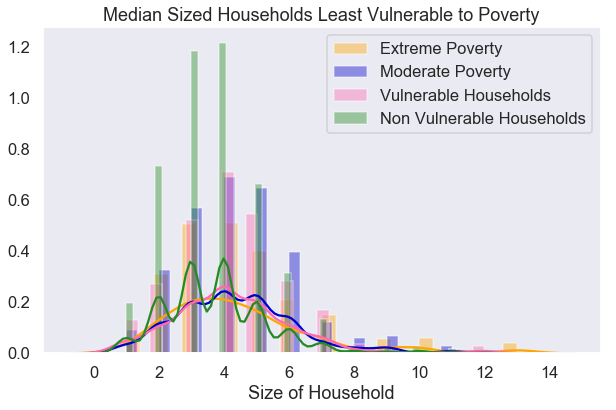

In [14]:
def distplot(feature):
    fig, ax = plt.subplots(1,1,figsize=(10,6))

    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==1)] ,color='orange', ax=ax)
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==2)] ,color='mediumblue', ax=ax )
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==3)] ,color='hotpink', ax=ax )
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==4)] ,color='forestgreen', ax=ax )

    plt.legend(['Extreme Poverty', 'Moderate Poverty', 'Vulnerable Households', 'Non Vulnerable Households'])

distplot('tamhog')
plt.title('Median Sized Households Least Vulnerable to Poverty')
plt.xlabel('Size of Household')

Text(0.5,0,'Size of Household')

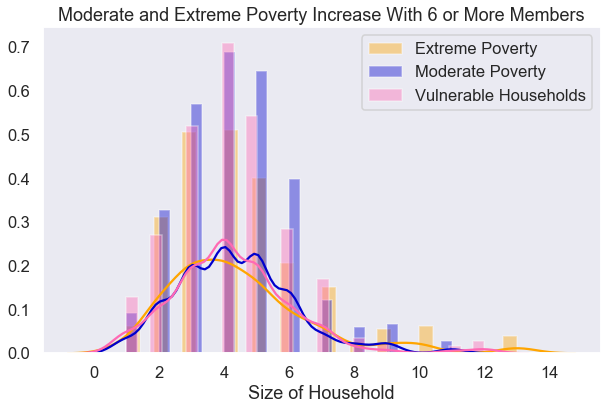

In [15]:
def distplot_vulnerable(feature):
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==1)] ,color='orange', ax=ax)
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==2)] ,color='mediumblue', ax=ax)
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==3)] ,color='hotpink', ax=ax )

    plt.legend(['Extreme Poverty', 'Moderate Poverty', 'Vulnerable Households'])

distplot_vulnerable('tamhog')
plt.title('Moderate and Extreme Poverty Increase With 6 or More Members')
plt.xlabel('Size of Household')

To understand if poverty is a cause or result of household size, we can drill down into the metrics around the subset of data that contains households above five people. Since we do not have econometric data, such as income, to make this analysis easy, we can evaluate the makeup of the household residents (school aged, working age, or old age) and the average education of the adults in the household. We can also see the overcrowding per bedroom to understand if many people are crammed into small houses, are many people are living in larger houses they may not be able to afford.

Text(0,0.5,'Avg Schooling for Adults')

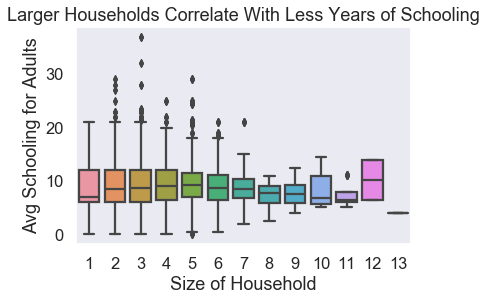

In [35]:
large_household = train[train['tamhog'] > 0]
sns.boxplot(large_household['tamhog'],large_household['meaneduc'])
plt.title('Larger Households Correlate With Less Years of Schooling')
plt.xlabel('Size of Household')
plt.ylabel('Avg Schooling for Adults')

The box-and-whisker plot shows us that the average years of education for all the adults tends to decrease as the size of the household increases. This could provide insight about the type of income levels that these houses may have: less education tends to inhibit access to higher paying jobs. Since we do not know the incomes of these households, the correlation of decreasing average years of schooling with increasing household size hints that poverty may be a result of less schooling.

Text(0,0.5,'Avg Schooling for Male Head')

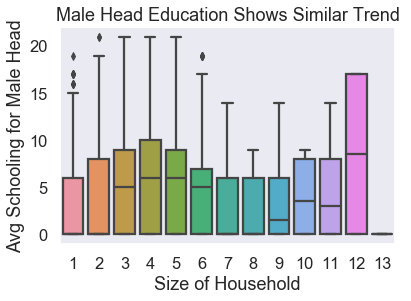

In [82]:
large_household = train[train['tamhog'] > 0]
large_household['edjefe'] = pd.to_numeric(large_household['edjefe'], errors='coerce').fillna(0).astype(np.int64)
sns.boxplot(large_household['tamhog'],large_household['edjefe'])
plt.title('Male Head Education Shows Similar Trend')
plt.xlabel('Size of Household')
plt.ylabel('Avg Schooling for Male Head')

In [71]:
len(train[train['tamhog'] == 12])

24

When we evaluate the male education and drill down on the larger households, we see that when households have between 7 to 9 people, the median years of schooling for the male head of household is either zero or below 5 years. However, as the household size increases to 10 or 11, the male head's education increases slightly. The households with 12 people is a clear outlier from this trend. This may be due to the fact that only 24 data points out of the 9557 fall within this category. Both households of 10 and 11 are equally sparse, as we see from the above countplot, so the trend is most clearly demonstrated with households within the 6-9 range. 

In [116]:
large_household = train[train['tamhog'] > 5]
large_household['meaneduc'].value_counts().sort_values(ascending=False)[:8]

6.0     78
7.5     72
11.0    62
9.0     53
10.0    51
8.0     50
Name: meaneduc, dtype: int64

In [117]:
small_household = train[train['tamhog'] <= 5]
small_household['meaneduc'].value_counts().sort_values(ascending=False)[:8]

6.0     768
11.0    429
9.0     345
8.5     296
7.0     288
10.0    279
8.0     256
Name: meaneduc, dtype: int64

If we evaluate the years of education between smaller households (less than 6 people) and larger households (greater than or equal to 6 people), we see that although the box and whisker plots show that there is a decreasing trend in terms of years of education as household size increases, this may be due to the fact that there are a lot less data points that represent larger housholds. The mean education overall is 6 years, and the overall the larger households have the same mean education (with nore representation in 7.5 years of education) as the smaller households.

This means that although education plays a role in helping us understand the income makeup, and perhaps the correlation between household size and poverty, it does not paint the entire picture. We can look at the age makeup of these different household sizes to further understand how many working adults are in these households, and thus understand how many people can contribute income to the household. The way we can evaluate this is to look at the number of children in each house.

Text(0.5,0,'Number of Children Under 18')

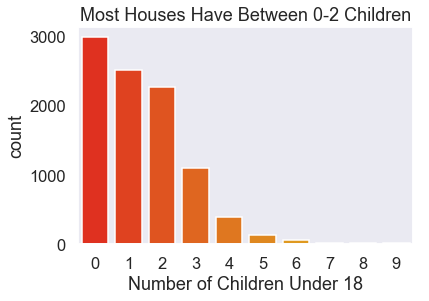

In [118]:
sns.countplot(train['hogar_nin'], palette=("autumn"))
plt.title('Most Houses Have Between 0-2 Children')
plt.xlabel('Number of Children Under 18')

Note: Smaller Homes means homes with less than six people.


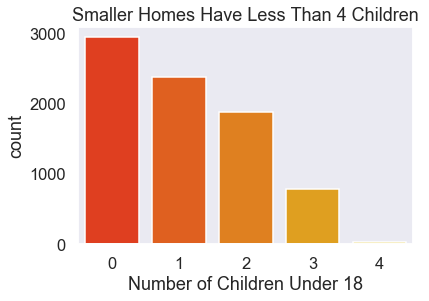

In [122]:
sns.countplot(small_household['hogar_nin'], palette=("autumn"))
plt.title('Smaller Homes Have Less Than 4 Children')
plt.xlabel('Number of Children Under 18')
print('Note: Smaller Homes means homes with less than six people.')

Note: Larger Homes means homes with more than, or equal to, six people.


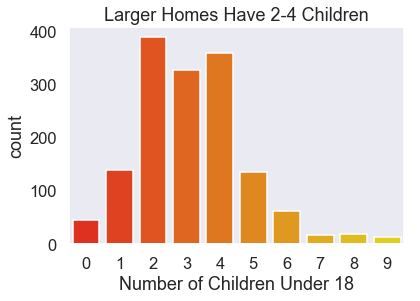

In [123]:
sns.countplot(large_household['hogar_nin'], palette=("autumn"))
plt.title('Larger Homes Have 2-4 Children')
plt.xlabel('Number of Children Under 18')
print('Note: Larger Homes means homes with more than, or equal to, six people.')

From these graphs, we can see that smaller households have less children - between 0 and 3. However, large households have as many as 9 children. Large households tend to the most concentration between 2-4 children. We can look at the range of 6-9 (household size) and compare it to 10-12 (household size) to see if there's a pattern that aligns with the pattern seen with mean years of education (above).

Text(0.5,0,'Number of Children Under 18')

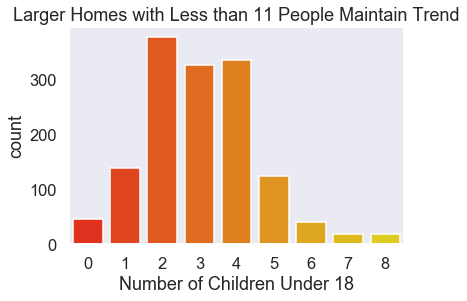

In [124]:
large_household_1 = train[(train['tamhog'] > 5) & (train['tamhog'] <= 10)]
sns.countplot(large_household_1['hogar_nin'], palette=("autumn"))
plt.title('Larger Homes with Less than 11 People Maintain Trend')
plt.xlabel('Number of Children Under 18')

Text(0.5,0,'Number of Children Under 18')

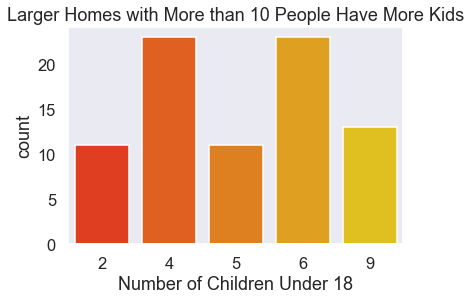

In [125]:
large_household_2 = train[train['tamhog'] > 10]
sns.countplot(large_household_2['hogar_nin'], palette=("autumn"))
plt.title('Larger Homes with More than 10 People Have More Kids')
plt.xlabel('Number of Children Under 18')

We can see that larger households have more children. This could be the reason why larger households correlate with poverty levels. As we tweak the large_household_2 threhold, we can see that the number of children count per size of household increase. 

At a household with 12 people, the majority of houses contain 9 children; the others have 4 or 6 children. This shows that even if the mean education of the household is high at that household size, a house with more children could contribute to poverty rather than education. 

This could mean that for households between 6 to 9 people, the main driver of poverty is education level, while households that are larger suffer from poverty due to the number of children to take care of.

### Years of Schooling
The most common education levels are no schooling, 6 years of schooling and 11 years of schooling. As schooling increases, the vulnerability to poverty decreases according to the distplots. Extreme poverty is most prevalent in among people who have no schooling. Moderate poverty is most common among households with less than 6 years of schooling. The number of vulnerable households peak at 5 and 11 years of schooling, further indicating the trend that higher levels of education lead to less vulnerability to poverty.

Text(0.5,0,'Years of Schooling')

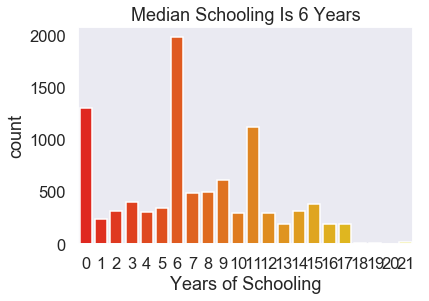

In [219]:
sns.countplot(train['escolari'][train['escolari'].notnull()], palette=("autumn"))
plt.title('Median Schooling Is 6 Years')
plt.xlabel('Years of Schooling')

Text(0.5,0,'Size of Household')

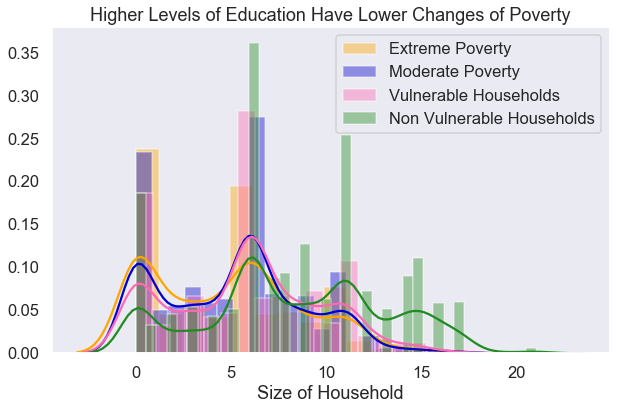

In [178]:
distplot('escolari')
plt.title('Higher Levels of Education Have Lower Changes of Poverty')
plt.xlabel('Years of Schooling')

Text(0.5,0,'Years of Schooling')

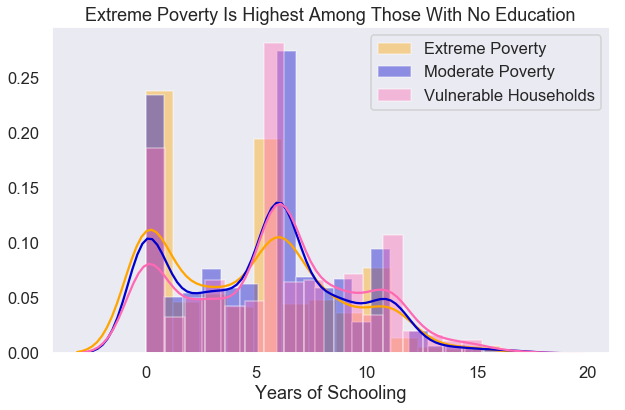

In [179]:
distplot_vulnerable('escolari')
plt.title('Extreme Poverty Is Highest Among Those With No Education')
plt.xlabel('Years of Schooling')

### Monthly Rent Payment
The distribution of rent payments skews right, with the most common rent payment being in the 1000,000 range. There are 6860 null values in the rent payment column, and 2697 populated values. The mean rent is 165,231 colon. Our analysis shows us that extreme poverty households tend to have lower monthly rent payments. Vulnerable households tend to have rent payments around the median value of 130,000 colon. This means that rent payments could be a good feature to help better predict poverty.

In [180]:
train['v2a1'].isnull().sum()

6860

In [234]:
train['v2a1'].dropna(inplace=True)
len(train['v2a1'])

2697

In [211]:
np.mean(train['v2a1'][train['v2a1'].notnull()])

165231.60697070821

In [237]:
np.median(train['v2a1'][train['v2a1'].notnull()])

130000.0

Text(0.5,0,'Rent in 100,000 Colon')

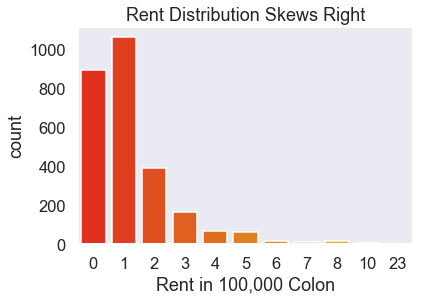

In [127]:
def rent_classify_int(x):
    return int(x/100000)

sns.countplot(train['v2a1'][train['v2a1'].notnull()].apply(rent_classify_int), palette=("autumn"))
plt.title('Rent Distribution Skews Right')
plt.xlabel('Rent in 100,000 Colon')

In [146]:
def rent_classify(x):
    return x/100000

train['rent'] = train['v2a1'][train['v2a1'].notnull()].apply(rent_classify)
train['rent'].value_counts().head()

1.5    233
1.0    181
2.0    159
1.2    149
0.5    118
Name: rent, dtype: int64

Frrom this graph, we can see that most of the rent falls below the median rent of 130,000 Colon. To understand more about what types of populations have this kind of rent, we can then look at the distribution plot of rent with poverty levels, as well as dig into what household sizes we see fall within the below average rent data set. 

Text(0.5,0,'Rent in 100,000 Colon')

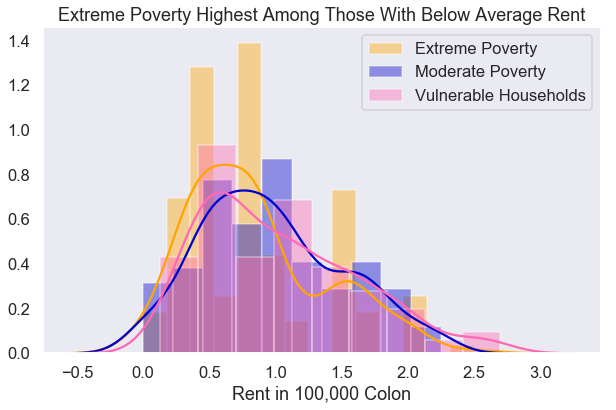

In [147]:
distplot_vulnerable('rent')
plt.title('Extreme Poverty Highest Among Those With Below Average Rent')
plt.xlabel('Rent in 100,000 Colon')

We can see that houses with lower than average rent have a higher distribution of extreme or moderate poverty levels. As our data around rent is sparse, we can look at the household size and see if larger homes tend to have higher rent, thus giving us more insight into how rent plays a role in the picture of poverty.

Text(0.5,1,'Large Households Tend To Pay More in Rent')

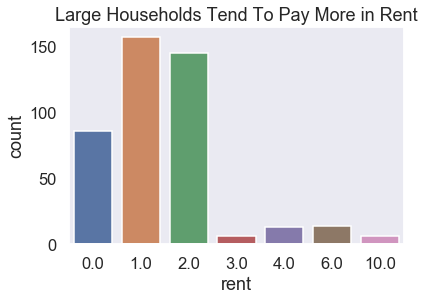

In [176]:
import warnings
warnings.filterwarnings('ignore')

large_household = train[train['tamhog'] > 5]
large_household['rent'].fillna(0)
large_household['rent'] = large_household['rent'].round(0)
sns.countplot(large_household['rent'])
plt.title('Large Households Tend To Pay More in Rent')

Text(0.5,1,'Small Households Tend To Pay The Average in Rent')

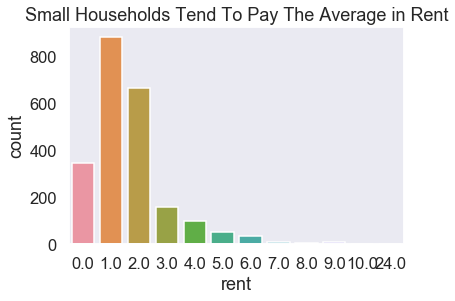

In [177]:
small_household = train[train['tamhog'] <= 5]
small_household['rent'].fillna(0)
small_household['rent'] = small_household['rent'].round(0)
sns.countplot(small_household['rent'])
plt.title('Small Households Tend To Pay The Average in Rent')

We can see that the large households have the same mode as the small households (100,000 colon), however the large housholds second most common rounded rent number is 200,000 Colon. This is true for small households as well, but here is a much larger gap betwen the most common and second most common rent values, whereas in large houses, there are almost as many people paying double the average rent.

Text(0.5,1,'Larger Households Tend To Pay More in Rent')

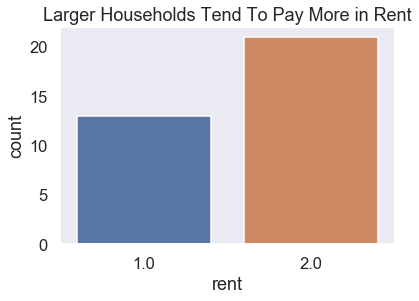

In [178]:
large_household = train[train['tamhog'] > 9]
large_household['rent'].fillna(0)
large_household['rent'] = large_household['rent'].round(0)
sns.countplot(large_household['rent'])
plt.title('Larger Households Tend To Pay More in Rent')

If we look at larger households (with more than 9 people), we see that there are more people paying 200,000 Colon. However, the gap in the metrics around household size is not enough to paint the picture behind the role of rent in poverty. We can also look at how rent correlates with education to see if there's a certain rent level that correlates with education level.

Text(0.5,1,'Less Educated Households Tend To Pay Less in Rent')

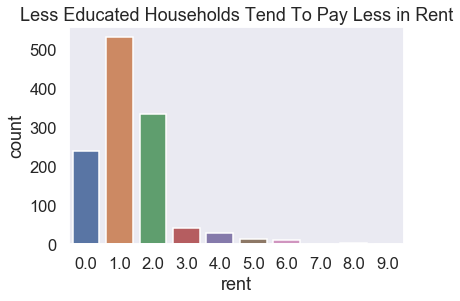

In [188]:
less_educ = train[train['escolari'] <= 6]
less_educ['rent'].fillna(0)
less_educ['rent'] = less_educ['rent'].round(0)
sns.countplot(less_educ['rent'])
plt.title('Less Educated Households Tend To Pay Less in Rent')

Text(0.5,1,'More Educated Households Tend To Pay More in Rent')

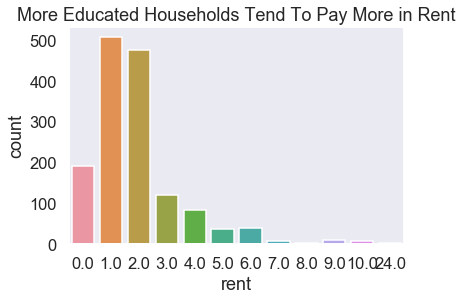

In [189]:
more_educ = train[train['escolari'] > 6]
more_educ['rent'].fillna(0)
more_educ['rent'] = more_educ['rent'].round(0)
sns.countplot(more_educ['rent'])
plt.title('More Educated Households Tend To Pay More in Rent')

We can see that rent prices are higher for households with higher education, with more households paying 200,000 Colon for rent than the less educated households. We can look at the household size to understand if education and household size can explain why more educated households pay more in rent but are less vulnerable to poverty.

Text(0,0.5,'Household Size')

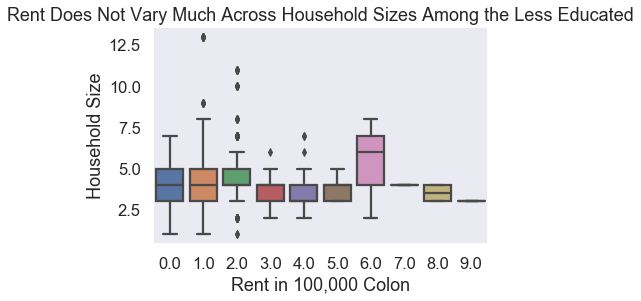

In [196]:
sns.boxplot(less_educ['rent'],less_educ['tamhog'])
plt.title('Rent Does Not Vary Much Across Household Sizes Among the Less Educated')
plt.xlabel('Rent in 100,000 Colon')
plt.ylabel('Household Size')

Text(0,0.5,'Household Size')

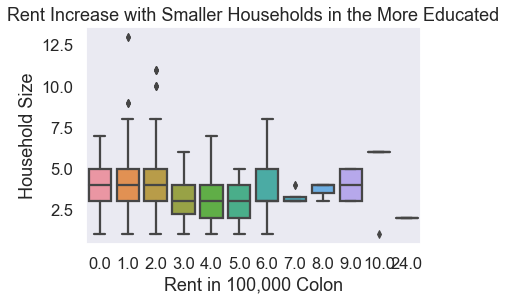

In [199]:
sns.boxplot(more_educ['rent'],more_educ['tamhog'])
plt.title('Rent Increase with Smaller Households in the More Educated')
plt.xlabel('Rent in 100,000 Colon')
plt.ylabel('Household Size')

If we look at the rent between 3 - 5 (in 100,000 Colons), we see that the household size (measured by the median) has dropped compared to the households paying lower rent among the more educated population (people with more than 6 years in schooling). This could be because the more educated people with smaller households are able to afford higher rent than those with bigger families. 

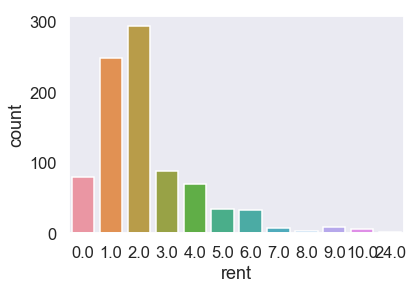

In [201]:
more_educ_1 = train[train['escolari'] > 10]
more_educ_1['rent'].fillna(0)
more_educ_1['rent'] = more_educ_1['rent'].round(0)
sns.countplot(more_educ_1['rent'])

If we look at the population with more than 11 years of schooling, we see that most of them pay more than double the average rent, with the mode being 200,000 Colon. There are far less people with a reported rent of 0 as compared to the less educated population. This could mean that the more educated people can afford higher places, and that the locations themselves could also make them less vulnerable to poverty, alongside their education level and income level. We can look at their household size to get a clearer picture of how this population compares to the populations with less than or equal to 6 years of schooling (less_educ) and more than 6 years of schooling.

Text(0,0.5,'Household Size')

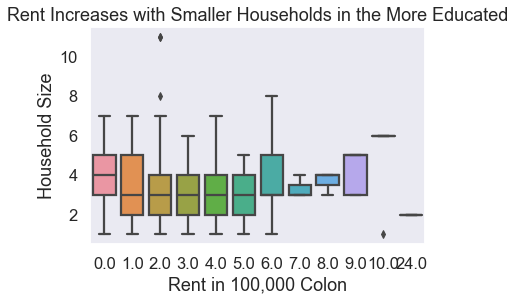

In [203]:
sns.boxplot(more_educ_1['rent'],more_educ_1['tamhog'])
plt.title('Rent Increases with Smaller Households in the More Educated')
plt.xlabel('Rent in 100,000 Colon')
plt.ylabel('Household Size')

Household size among this population (more than 11 years in schooling) is smaller than both of the previous segmentations we have looked at - the median hovered around 5 across the less educated population and more educated population, but we see that these households with more than 11 years in schooling have a median of around 3 people in their houses (excluding the outliers of over 500,000 Colon). This means that more education correlates with smaller households.

In summary, when we look at household size, education level and rent, the picture of poverty is complex: bigger households tend to be more prone to poverty and also tend to have less average education within the house. They tend to have lower rent, however this does not seem to protect them from poverty. Smaller households correlate with higher average education within the house, and can also correlate with higher rent. This does not seem to cause poverty, as this population is less prone to poverty. This means that it is likely that rent is not what correlates with poverty, but instead, education level and household size. Education of family planning could help prevent poverty in households with larger size and less overall education.